# Adding explainability to the models - KernelSHAP

## Import libraries, data, and models

In [1]:
set.seed(1313)
#to have reproducible results

In [2]:
#Import data 
testing <-  read.csv(file.path('testing.csv'))
training <-  read.csv(file.path('training.csv'))

testing$HeartDisease <- as.factor(testing$HeartDisease)
testing$Sex <- as.factor(testing$Sex)
testing$ChestPainType <- as.factor(testing$ChestPainType)
testing$FastingBS <- as.factor(testing$FastingBS)
testing$RestingECG <- as.factor(testing$RestingECG)
testing$ExerciseAngina <- as.factor(testing$ExerciseAngina)
testing$ST_Slope <- as.factor(testing$ST_Slope)

row.names(testing) <- NULL

training$HeartDisease <- as.factor(training$HeartDisease)
training$Sex <- as.factor(training$Sex)
training$ChestPainType <- as.factor(training$ChestPainType)
training$FastingBS <- as.factor(training$FastingBS)
training$RestingECG <- as.factor(training$RestingECG)
training$ExerciseAngina <- as.factor(training$ExerciseAngina)
training$ST_Slope <- as.factor(training$ST_Slope)
  
row.names(training) <- NULL

In [3]:
#Import models

library(stats)
lr.heartdisease <- readRDS("lr.rds")

library(randomForest)
rf.heartdisease <- readRDS("rf.rds")

#install.packages('e1071')
library(e1071)
svm.heartdisease <- readRDS("svm.rds")

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.
Warning message:
"package 'e1071' was built under R version 3.6.3"

**Import XAI packages** - with installation time analysis. After, run if necessary

In [4]:
# shapper - for kernelSHAP
# instal shapper 
#system.time(install.packages("shapper")) - already installed

## Explanations

### Prepare predictors and explanators 

In [4]:
head(training)
label.idx = 12

Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0


In [5]:
data_train = training[,-label.idx]
labels_train = training[,label.idx]

**For local explanations**

In [6]:
i=16 # Patient A
instance = testing[i,-label.idx]
instance
paste0("true label: ", testing[i,label.idx], " - with heart disease")

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
16,57,M,ATA,140,265,0,ST,145,Y,1,Flat


[1] "true label: 1 - with heart disease"

In [7]:
data.frame("C0" = 1- predict(lr.heartdisease,instance, type ="response"),
           "C1" = predict(lr.heartdisease,instance, type ="response"))
predict(rf.heartdisease, instance, type="prob")
attr(predict(svm.heartdisease, instance, probability = TRUE), "probabilities")

,C0,C1
16,0.1028879,0.8971121


,0,1
16,0.15,0.85


,0,1
16,0.1158874,0.8841126


In [8]:
i=27 # Patient B
instance2 = testing[i,-label.idx]
instance2
paste0("true label: ", testing[i,label.idx], " - healthy")

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
27,38,M,ATA,140,297,0,Normal,150,N,0,Up


[1] "true label: 0 - healthy"

In [9]:
data.frame("C0" = 1- predict(lr.heartdisease,instance2, type ="response"),
           "C1" = predict(lr.heartdisease,instance2, type ="response"))
predict(rf.heartdisease, instance, type="prob")
attr(predict(svm.heartdisease, instance2, probability = TRUE), "probabilities")

,C0,C1
27,0.9534874,0.04651257


,0,1
16,0.15,0.85


,0,1
27,0.9544355,0.04556445


In [10]:
i=35 #Patient C - heart disease with uncertain probability - close to 0.5
instance3 = testing[i,-label.idx]
instance3
paste0("true label: ", testing[i,label.idx], " - with heart disease")

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
35,49,M,NAP,115,265,0,Normal,175,N,0,Flat


[1] "true label: 1 - with heart disease"

In [11]:
round(data.frame("C0" = 1- predict(lr.heartdisease,instance3, type ="response"),
           "C1" = predict(lr.heartdisease,instance3, type ="response")),2)
predict(rf.heartdisease, instance3, type="prob")
round(attr(predict(svm.heartdisease, instance3, probability = TRUE), "probabilities"),2)

,C0,C1
35,0.63,0.37


,0,1
35,0.578,0.422


,0,1
35,0.54,0.46


In [12]:
#####For (kernel)shap
#create predictor for creation of ive objects (shap) - also necessary for CIU
pred_lr <- function(x, newdata, type,...) data.frame("C0" = 1-as.numeric(predict(x,newdata,type ="response")),
                                                    "C1" = as.numeric(predict(x,newdata, type ="response")))                             
pred_rf <- function(x, newdata, type,...) predict(x, newdata, type="prob")
pred_svm <- function(x, newdata,...) as.data.frame(attr(predict(x, newdata, probability = TRUE), "probabilities"))
library(shapper)

Warning message:
"package 'shapper' was built under R version 3.6.3"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


### KernelSHAP

#### Patient A

In [17]:
library(shapper)
#ive for individuable variable effect - patient A
system.time(ive_lr_long <- individual_variable_effect(lr.heartdisease, data = data_train, 
                                                 predict_function = pred_lr,new_observation = instance))
system.time(ive_rf_long <- individual_variable_effect(rf.heartdisease, data = data_train, 
                                                 predict_function = pred_rf, new_observation = instance))
system.time(ive_svm_long <- individual_variable_effect(svm.heartdisease, data = data_train, 
                                                  predict_function = pred_svm, new_observation = instance))
#default: nsamples = 2 * X.shape[1] + 2048 = 2070 - this takes a looooong time; 
#next the same but with nsamples=100, like in shapley and ciu; 

   user  system elapsed 
  20.45    3.89   58.62 

   user  system elapsed 
  40.53    0.75   44.72 

   user  system elapsed 
  42.97    0.86   47.02 

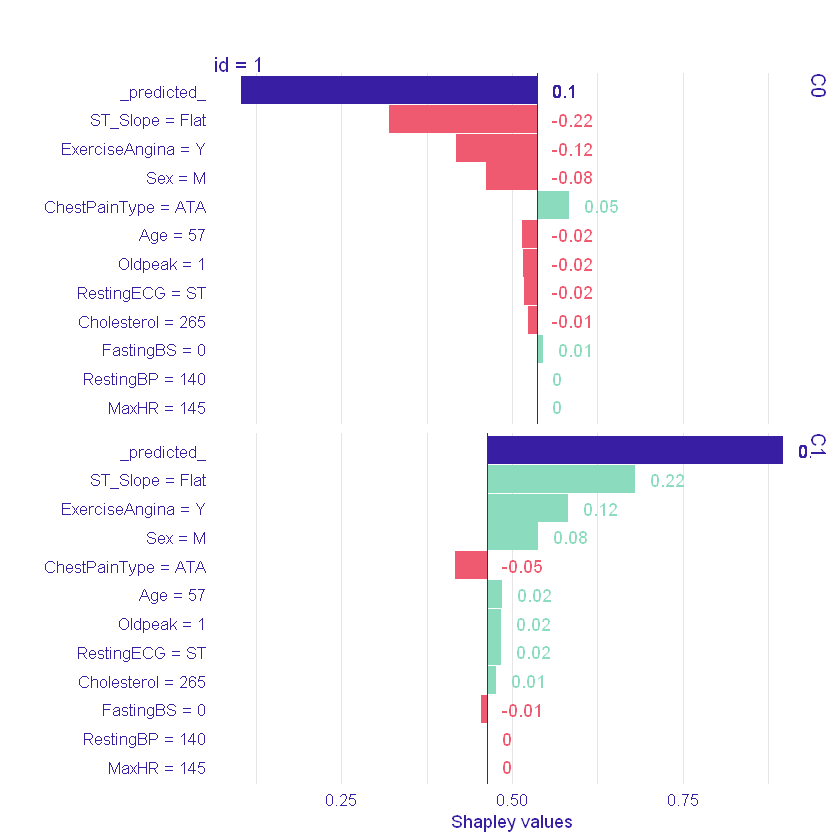

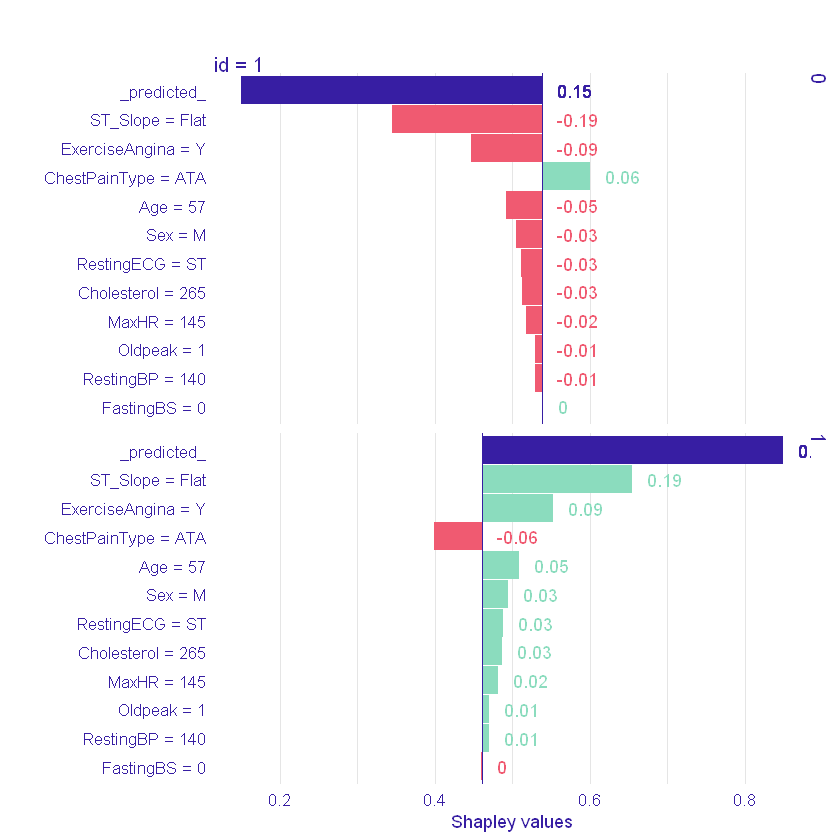

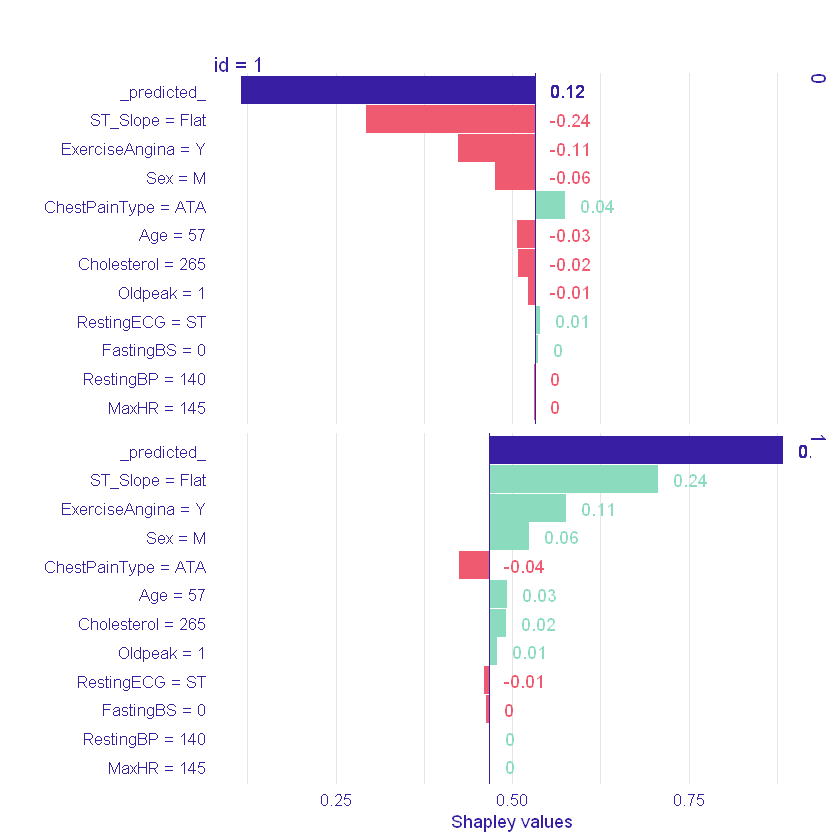

In [18]:
plot(ive_lr_long)
plot(ive_rf_long)
plot(ive_svm_long)

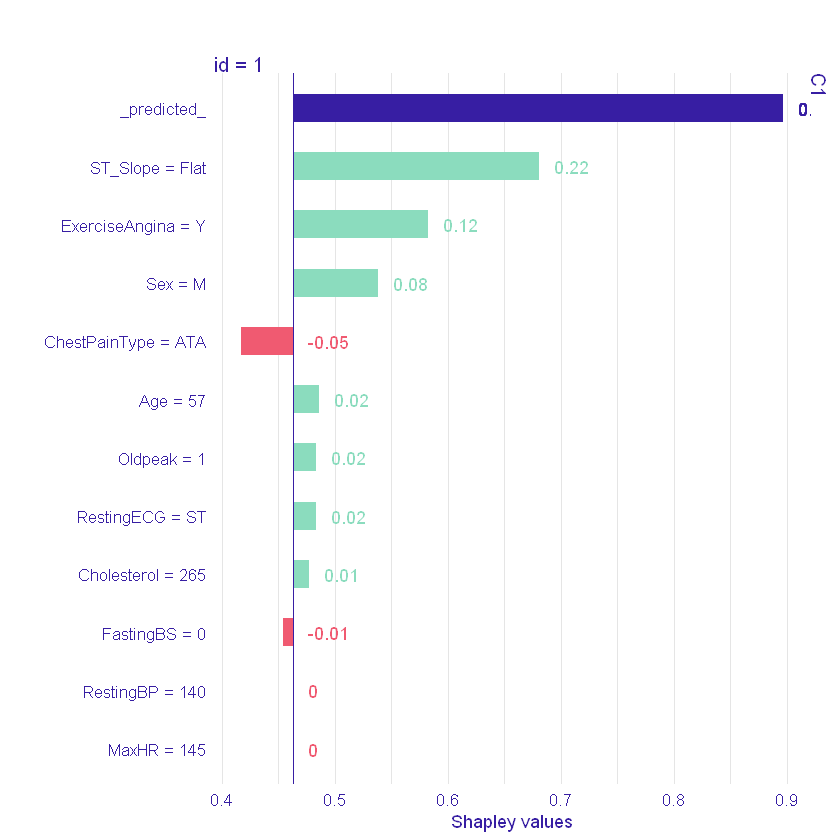

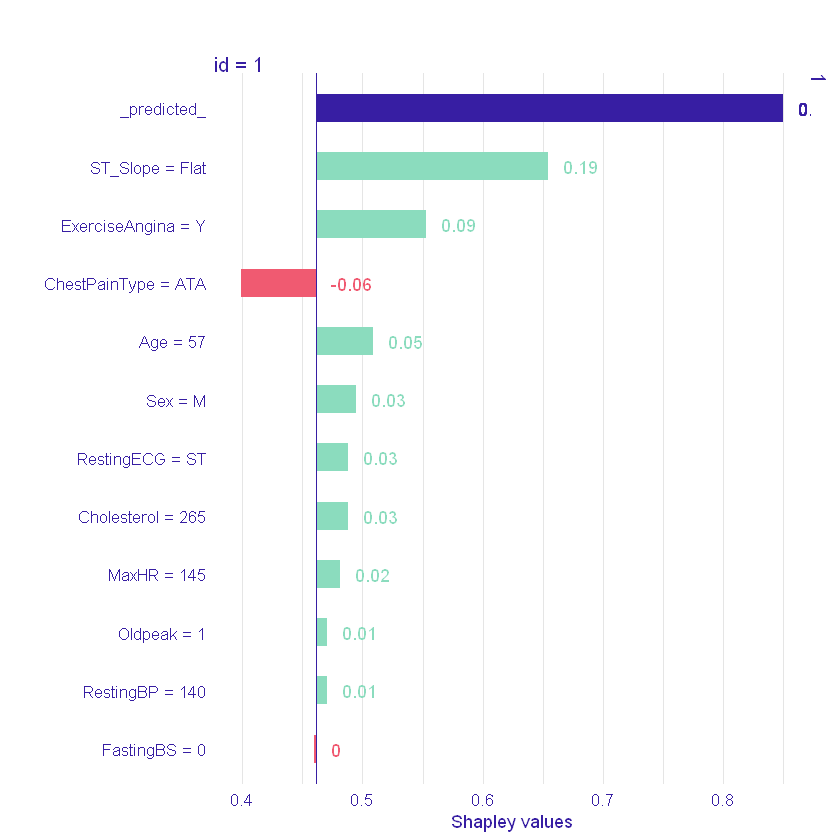

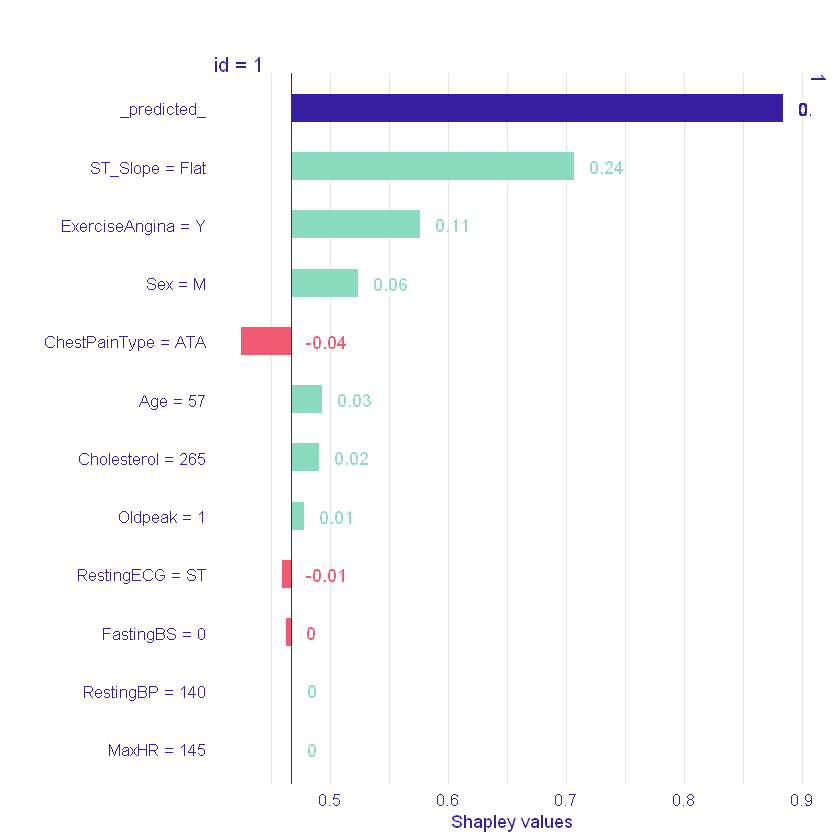

In [19]:
# filtered lr- only class 1
ive_lr_filtered <- dplyr::filter(ive_lr_long, `_ylevel_` == "C1")
shapper:::plot.individual_variable_effect(ive_lr_filtered)
# filtered rf- only class 1
ive_rf_filtered <- dplyr::filter(ive_rf_long, `_ylevel_` == "1")
shapper:::plot.individual_variable_effect(ive_rf_filtered)
# filtered svm- only class 1
ive_svm_filtered <- dplyr::filter(ive_svm_long, `_ylevel_` == "1")
shapper:::plot.individual_variable_effect(ive_svm_filtered)

In [20]:
# sum of the shapley values (class 1, SVM model)
sum_shap <- sum(ive_svm_filtered["_attribution_"])
# f(x)-E[f(x)] = sum(shapley_values) ?
ive_svm_filtered["_yhat_"][1,] - ive_svm_filtered["_yhat_mean_"][1,] == sum_shap

[1] TRUE

In [21]:
ive_lr_long
ive_rf_long
ive_svm_long

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,_id_,_ylevel_,_yhat_,_yhat_mean_,_vname_,_attribution_,_sign_,_label_
16,57,M,ATA,140,265,0,ST,145,Y,1,Flat,1,C0,0.1028879,0.5370019,Age,-0.0225241466,-,lm
16.2,57,M,ATA,140,265,0,ST,145,Y,1,Flat,1,C0,0.1028879,0.5370019,Sex,-0.0753676565,-,lm
16.3,57,M,ATA,140,265,0,ST,145,Y,1,Flat,1,C0,0.1028879,0.5370019,ChestPainType,0.0462407012,+,lm
16.4,57,M,ATA,140,265,0,ST,145,Y,1,Flat,1,C0,0.1028879,0.5370019,RestingBP,0.0002143455,+,lm
16.5,57,M,ATA,140,265,0,ST,145,Y,1,Flat,1,C0,0.1028879,0.5370019,Cholesterol,-0.0138860067,-,lm
16.6,57,M,ATA,140,265,0,ST,145,Y,1,Flat,1,C0,0.1028879,0.5370019,FastingBS,0.0086522568,+,lm
16.7,57,M,ATA,140,265,0,ST,145,Y,1,Flat,1,C0,0.1028879,0.5370019,RestingECG,-0.0202114934,-,lm
16.8,57,M,ATA,140,265,0,ST,145,Y,1,Flat,1,C0,0.1028879,0.5370019,MaxHR,0.0000674028,+,lm
16.9,57,M,ATA,140,265,0,ST,145,Y,1,Flat,1,C0,0.1028879,0.5370019,ExerciseAngina,-0.1194191499,-,lm
16.10,57,M,ATA,140,265,0,ST,145,Y,1,Flat,1,C0,0.1028879,0.5370019,Oldpeak,-0.0204363312,-,lm


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,_id_,_ylevel_,_yhat_,_yhat_mean_,_vname_,_attribution_,_sign_,_label_
16,57,M,ATA,140,265,0,ST,145,Y,1,Flat,1,0,0.15,0.5382884,Age,-0.046688559,-,randomForest
16.2,57,M,ATA,140,265,0,ST,145,Y,1,Flat,1,0,0.15,0.5382884,Sex,-0.033121427,-,randomForest
16.3,57,M,ATA,140,265,0,ST,145,Y,1,Flat,1,0,0.15,0.5382884,ChestPainType,0.062823698,+,randomForest
16.4,57,M,ATA,140,265,0,ST,145,Y,1,Flat,1,0,0.15,0.5382884,RestingBP,-0.008588375,-,randomForest
16.5,57,M,ATA,140,265,0,ST,145,Y,1,Flat,1,0,0.15,0.5382884,Cholesterol,-0.025920692,-,randomForest
16.6,57,M,ATA,140,265,0,ST,145,Y,1,Flat,1,0,0.15,0.5382884,FastingBS,0.001972130,+,randomForest
16.7,57,M,ATA,140,265,0,ST,145,Y,1,Flat,1,0,0.15,0.5382884,RestingECG,-0.026303488,-,randomForest
16.8,57,M,ATA,140,265,0,ST,145,Y,1,Flat,1,0,0.15,0.5382884,MaxHR,-0.019702774,-,randomForest
16.9,57,M,ATA,140,265,0,ST,145,Y,1,Flat,1,0,0.15,0.5382884,ExerciseAngina,-0.091081226,-,randomForest
16.10,57,M,ATA,140,265,0,ST,145,Y,1,Flat,1,0,0.15,0.5382884,Oldpeak,-0.008829225,-,randomForest


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,_id_,_ylevel_,_yhat_,_yhat_mean_,_vname_,_attribution_,_sign_,_label_
16,57,M,ATA,140,265,0,ST,145,Y,1,Flat,1,0,0.1158874,0.5330397,Age,-0.026150136,-,svm
16.2,57,M,ATA,140,265,0,ST,145,Y,1,Flat,1,0,0.1158874,0.5330397,Sex,-0.057164756,-,svm
16.3,57,M,ATA,140,265,0,ST,145,Y,1,Flat,1,0,0.1158874,0.5330397,ChestPainType,0.042264035,+,svm
16.4,57,M,ATA,140,265,0,ST,145,Y,1,Flat,1,0,0.1158874,0.5330397,RestingBP,-0.001449659,-,svm
16.5,57,M,ATA,140,265,0,ST,145,Y,1,Flat,1,0,0.1158874,0.5330397,Cholesterol,-0.024019702,-,svm
16.6,57,M,ATA,140,265,0,ST,145,Y,1,Flat,1,0,0.1158874,0.5330397,FastingBS,0.003769332,+,svm
16.7,57,M,ATA,140,265,0,ST,145,Y,1,Flat,1,0,0.1158874,0.5330397,RestingECG,0.007225041,+,svm
16.8,57,M,ATA,140,265,0,ST,145,Y,1,Flat,1,0,0.1158874,0.5330397,MaxHR,-0.001384980,-,svm
16.9,57,M,ATA,140,265,0,ST,145,Y,1,Flat,1,0,0.1158874,0.5330397,ExerciseAngina,-0.109640795,-,svm
16.10,57,M,ATA,140,265,0,ST,145,Y,1,Flat,1,0,0.1158874,0.5330397,Oldpeak,-0.011097489,-,svm


**This takes considerably less time!**

In [22]:
library(shapper)
#ive for individuable variable effect - patient A
system.time(ive_lr <- individual_variable_effect(lr.heartdisease, data = data_train, 
                                                 predict_function = pred_lr,new_observation = instance, nsamples=100))
system.time(ive_rf <- individual_variable_effect(rf.heartdisease, data = data_train, 
                                                 predict_function = pred_rf, new_observation = instance, nsamples=100))
system.time(ive_svm <- individual_variable_effect(svm.heartdisease, data = data_train, 
                                                  predict_function = pred_svm, new_observation = instance, nsamples=100))
#the same but with nsamples=100, like in shapley and ciu - consistency

   user  system elapsed 
   1.03    0.05    1.15 

   user  system elapsed 
   1.94    0.00    1.96 

   user  system elapsed 
   2.47    0.00    2.48 

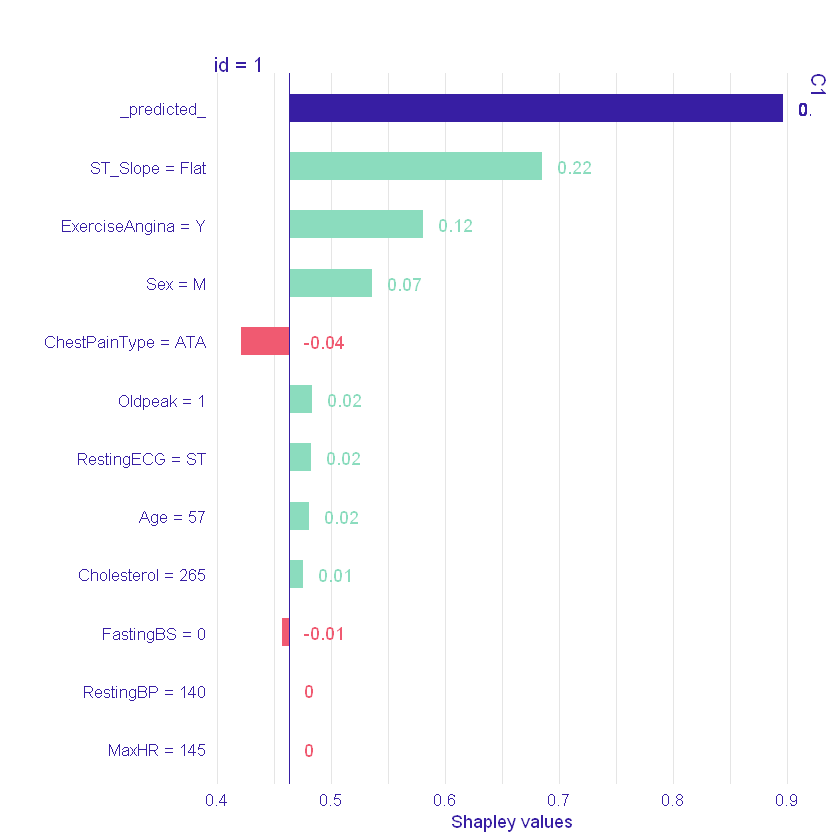

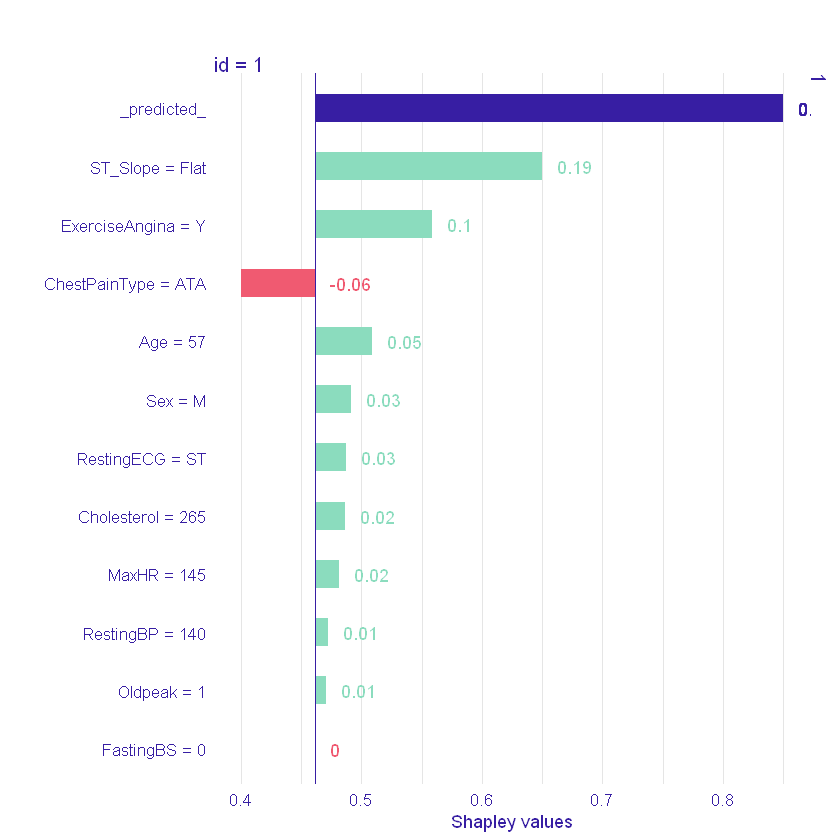

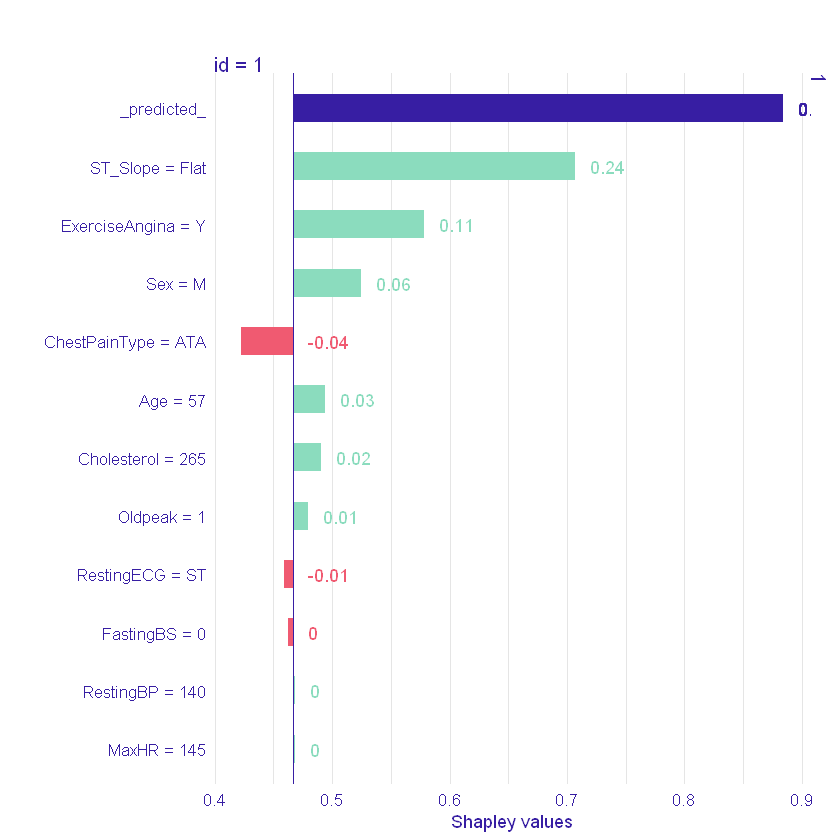

In [24]:
# filtered lr- only class 1
ive_lr_filtered <- dplyr::filter(ive_lr, `_ylevel_` == "C1")
shapper:::plot.individual_variable_effect(ive_lr_filtered)
# filtered rf- only class 1
ive_rf_filtered <- dplyr::filter(ive_rf, `_ylevel_` == "1")
shapper:::plot.individual_variable_effect(ive_rf_filtered)
# filtered svm- only class 1
ive_svm_filtered <- dplyr::filter(ive_svm, `_ylevel_` == "1")
shapper:::plot.individual_variable_effect(ive_svm_filtered)

In [25]:
# sum of the shapley values (class 1, SVM model)
sum_shap <- sum(ive_svm_filtered["_attribution_"])
# f(x)-E[f(x)] = sum(shapley_values) ?
ive_svm_filtered["_yhat_"][1,] - ive_svm_filtered["_yhat_mean_"][1,] == sum_shap

[1] TRUE

Let's see how similar the results are, considering different sample sizes

In [29]:
cbind(ive_lr_long["_attribution_"],ive_lr["_attribution_"])
cbind(ive_rf_long["_attribution_"],ive_rf["_attribution_"])
cbind(ive_svm_long["_attribution_"],ive_svm["_attribution_"])

,_attribution_,_attribution_
16,-0.0225241466,-0.017763746
16.2,-0.0753676565,-0.073000078
16.3,0.0462407012,0.042275476
16.4,0.0002143455,0.000000000
16.5,-0.0138860067,-0.012367487
16.6,0.0086522568,0.006242223
16.7,-0.0202114934,-0.019439602
16.8,0.0000674028,0.000000000
16.9,-0.1194191499,-0.117621313
16.10,-0.0204363312,-0.020440553


,_attribution_,_attribution_
16,-0.046688559,-0.046747681
16.2,-0.033121427,-0.029433837
16.3,0.062823698,0.061666392
16.4,-0.008588375,-0.010795185
16.5,-0.025920692,-0.024360638
16.6,0.001972130,0.000000000
16.7,-0.026303488,-0.025520680
16.8,-0.019702774,-0.019800394
16.9,-0.091081226,-0.096727817
16.10,-0.008829225,-0.008554569


,_attribution_,_attribution_
16,-0.026150136,-0.026968414
16.2,-0.057164756,-0.057602670
16.3,0.042264035,0.044678535
16.4,-0.001449659,-0.001388404
16.5,-0.024019702,-0.023402656
16.6,0.003769332,0.004827751
16.7,0.007225041,0.007598401
16.8,-0.001384980,-0.001288069
16.9,-0.109640795,-0.111545591
16.10,-0.011097489,-0.012436793


The shapley values obtained with the different sampling sizes are very similar. Most importantly, the explanation takes a reasonable amount of time to be given, which is preferable in real world scenarios. The accuracy of the results may decrease, but that also happens for the other methods. So, for consistency and usability, we will use from now on nsamples=100.

In [31]:
#Save local values for class 1 - phi (shapley values) patientA
#with nsamples=100
s_lr <- ive_lr[ive_lr["_ylevel_"] == "C1",]
lShap_lr = as.data.frame(s_lr["_attribution_"][,1])
rownames(lShap_lr) = s_lr["_vname_"][,1]
colnames(lShap_lr) = expression("kernelSHAP")
round(lShap_lr,2)
saveRDS(lShap_lr,file='Local_A/shap_LR.Rda')

s_rf <- ive_rf[ive_rf["_ylevel_"] == "1",]
lShap_rf = as.data.frame(s_rf["_attribution_"][,1])
rownames(lShap_rf) = s_rf["_vname_"][,1]
colnames(lShap_rf) = expression("kernelSHAP")
round(lShap_rf,2)
saveRDS(lShap_rf,file='Local_A/shap_RF.Rda')

s_svm <- ive_svm[ive_svm["_ylevel_"] == "1",]
lShap_svm = as.data.frame(s_svm["_attribution_"][,1])
rownames(lShap_svm) = s_svm["_vname_"][,1]
colnames(lShap_svm) = expression("kernelSHAP")
round(lShap_svm,2)
saveRDS(lShap_svm,file='Local_A/shap_SVM.Rda')

,kernelSHAP
Age,0.02
Sex,0.07
ChestPainType,-0.04
RestingBP,0.00
Cholesterol,0.01
FastingBS,-0.01
RestingECG,0.02
MaxHR,0.00
ExerciseAngina,0.12
Oldpeak,0.02


,kernelSHAP
Age,0.05
Sex,0.03
ChestPainType,-0.06
RestingBP,0.01
Cholesterol,0.02
FastingBS,0.00
RestingECG,0.03
MaxHR,0.02
ExerciseAngina,0.10
Oldpeak,0.01


,kernelSHAP
Age,0.03
Sex,0.06
ChestPainType,-0.04
RestingBP,0.00
Cholesterol,0.02
FastingBS,0.00
RestingECG,-0.01
MaxHR,0.00
ExerciseAngina,0.11
Oldpeak,0.01


The shapley values obtained with the different sampling sizes are very similar. Most importantly, the explanation takes a reasonable amount of time to be given, which is preferable in real world scenarios. The accuracy of the results may decrease, but that also happens for the other methods. So, for consistency and usability, we will use from now on nsamples=100.

#### Patient B

In [18]:
library(shapper)
#ive for individuable variable effect - patient B
system.time(ive_lr2 <- individual_variable_effect(lr.heartdisease, data = data_train, 
                                                 predict_function = pred_lr,new_observation = instance2, nsamples=100))
system.time(ive_rf2 <- individual_variable_effect(rf.heartdisease, data = data_train, 
                                                 predict_function = pred_rf, new_observation = instance2, nsamples=100))
system.time(ive_svm2 <- individual_variable_effect(svm.heartdisease, data = data_train, 
                                                  predict_function = pred_svm, new_observation = instance2, nsamples=100))

   user  system elapsed 
   1.07    0.00    1.08 

   user  system elapsed 
   2.19    0.00    2.30 

   user  system elapsed 
   2.53    0.03    2.59 

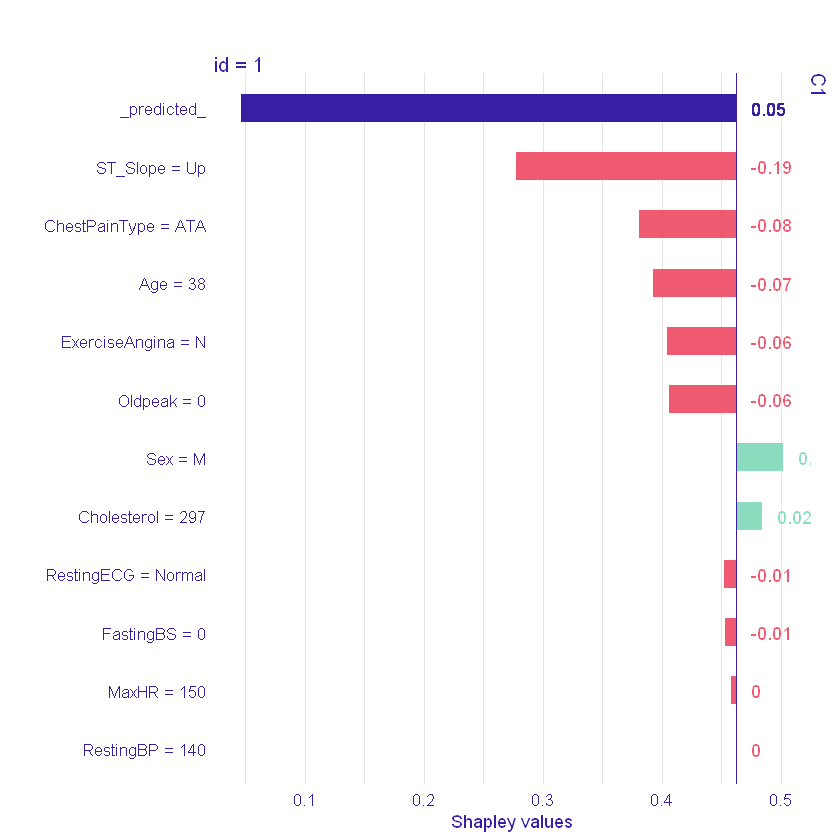

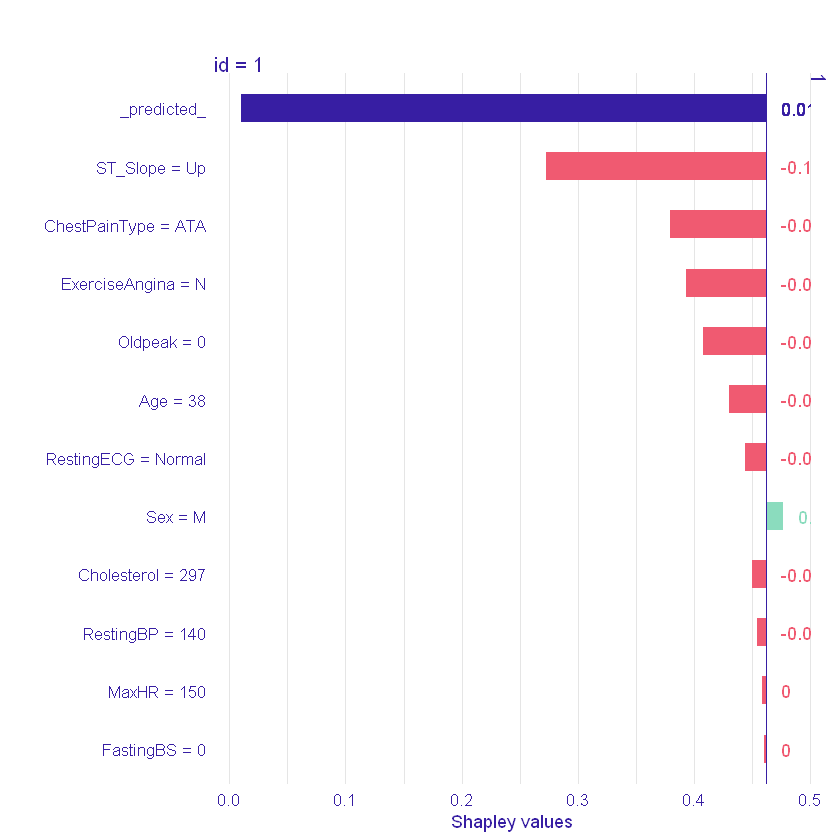

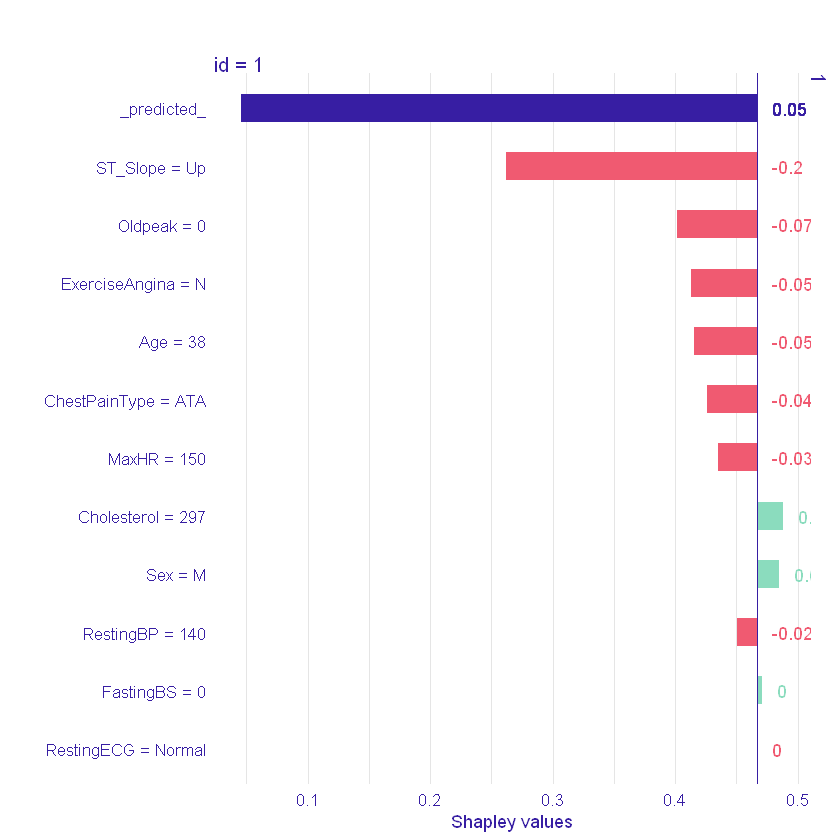

In [19]:
# filtered lr- only class 1
ive_lr_filtered2 <- dplyr::filter(ive_lr2, `_ylevel_` == "C1")
shapper:::plot.individual_variable_effect(ive_lr_filtered2)
# filtered rf- only class 1
ive_rf_filtered2 <- dplyr::filter(ive_rf2, `_ylevel_` == "1")
shapper:::plot.individual_variable_effect(ive_rf_filtered2)
# filtered svm- only class 1
ive_svm_filtered2 <- dplyr::filter(ive_svm2, `_ylevel_` == "1")
shapper:::plot.individual_variable_effect(ive_svm_filtered2)

In [20]:
#Save local values for class 1 - phi (shapley values) patient B
s_lr2 <- ive_lr2[ive_lr2["_ylevel_"] == "C1",]
lShap_lr2 = as.data.frame(s_lr2["_attribution_"][,1])
rownames(lShap_lr2) = s_lr2["_vname_"][,1]
colnames(lShap_lr2) = expression("kernelSHAP")
round(lShap_lr2,2)
saveRDS(lShap_lr2,file="Local_B/shap_LR.Rda")

s_rf2 <- ive_rf2[ive_rf2["_ylevel_"] == "1",]
lShap_rf2 = as.data.frame(s_rf2["_attribution_"][,1])
rownames(lShap_rf2) = s_rf2["_vname_"][,1]
colnames(lShap_rf2) = expression("kernelSHAP")
round(lShap_rf2,2)
saveRDS(lShap_rf2,file="Local_B/shap_RF.Rda")

s_svm2 <- ive_svm2[ive_svm2["_ylevel_"] == "1",]
lShap_svm2 = as.data.frame(s_svm2["_attribution_"][,1])
rownames(lShap_svm2) = s_svm2["_vname_"][,1]
colnames(lShap_svm2) = expression("kernelSHAP")
round(lShap_svm2,2)
saveRDS(lShap_svm2,file="Local_B/shap_SVM.Rda")

,kernelSHAP
Age,-0.07
Sex,0.04
ChestPainType,-0.08
RestingBP,0.00
Cholesterol,0.02
FastingBS,-0.01
RestingECG,-0.01
MaxHR,0.00
ExerciseAngina,-0.06
Oldpeak,-0.06


,kernelSHAP
Age,-0.03
Sex,0.02
ChestPainType,-0.08
RestingBP,-0.01
Cholesterol,-0.01
FastingBS,0.00
RestingECG,-0.02
MaxHR,0.00
ExerciseAngina,-0.07
Oldpeak,-0.05


,kernelSHAP
Age,-0.05
Sex,0.02
ChestPainType,-0.04
RestingBP,-0.02
Cholesterol,0.02
FastingBS,0.00
RestingECG,0.00
MaxHR,-0.03
ExerciseAngina,-0.05
Oldpeak,-0.07


#### Patient C

In [13]:
library(shapper)
#ive for individuable variable effect - patient B
system.time(ive_lr3 <- individual_variable_effect(lr.heartdisease, data = data_train, 
                                                 predict_function = pred_lr,new_observation = instance3, nsamples=100))
system.time(ive_rf3 <- individual_variable_effect(rf.heartdisease, data = data_train, 
                                                 predict_function = pred_rf, new_observation = instance3, nsamples=100))
system.time(ive_svm3 <- individual_variable_effect(svm.heartdisease, data = data_train, 
                                                  predict_function = pred_svm, new_observation = instance3, nsamples=100))

   user  system elapsed 
   2.22    1.23   19.66 

   user  system elapsed 
   1.94    0.00    1.97 

   user  system elapsed 
   1.94    0.01    1.96 

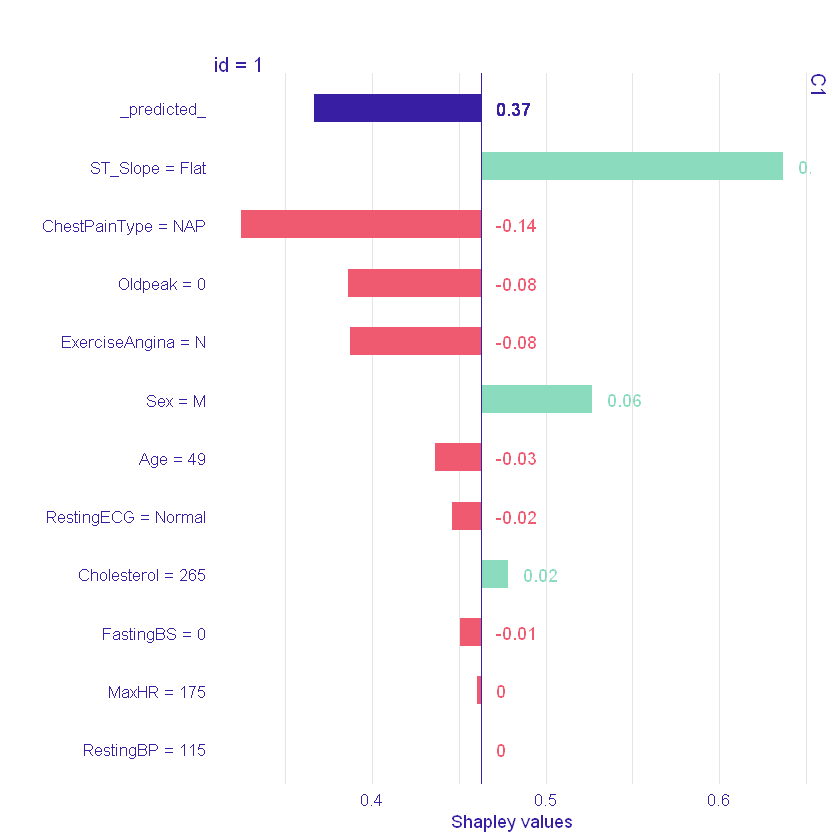

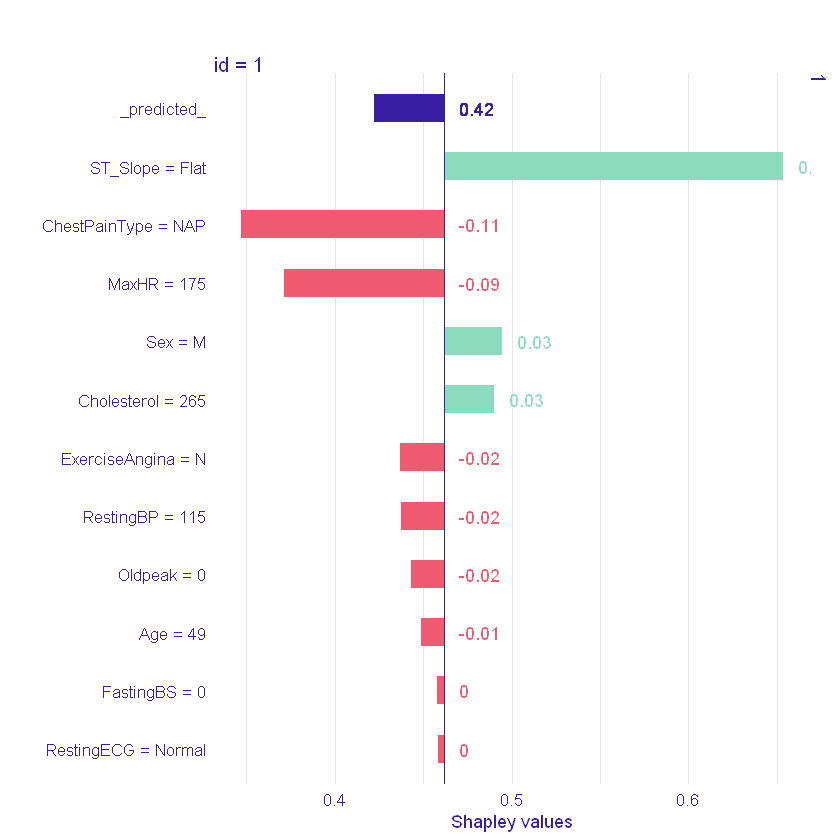

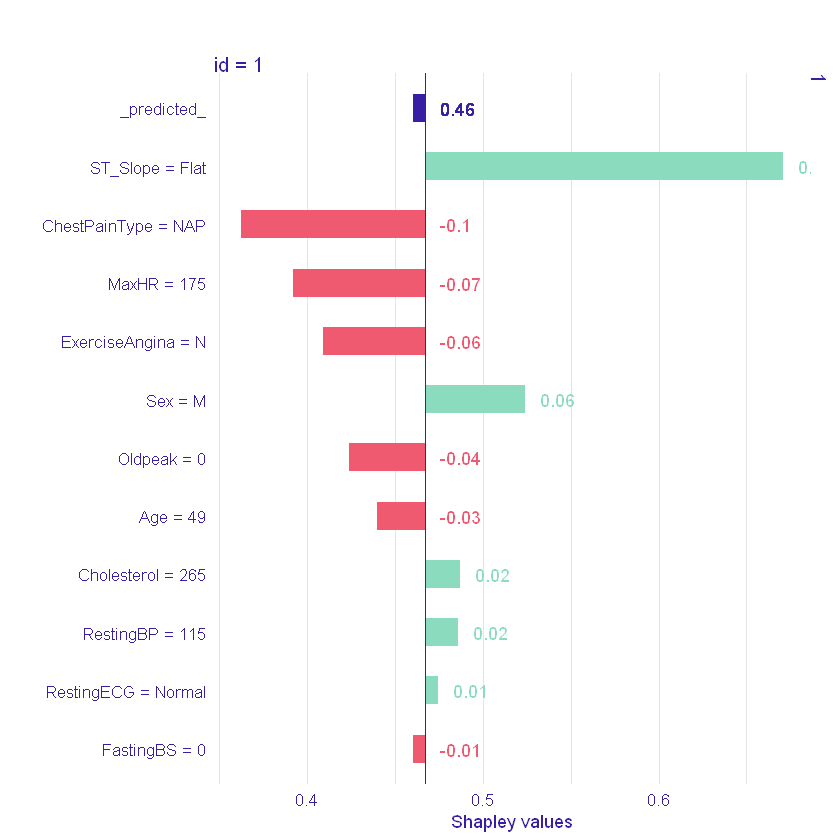

In [16]:
# filtered lr- only class 1
ive_lr_filtered3 <- dplyr::filter(ive_lr3, `_ylevel_` == "C1")
shapper:::plot.individual_variable_effect(ive_lr_filtered3)
# filtered rf- only class 1
ive_rf_filtered3 <- dplyr::filter(ive_rf3, `_ylevel_` == "1")
shapper:::plot.individual_variable_effect(ive_rf_filtered3)
# filtered svm- only class 1
ive_svm_filtered3 <- dplyr::filter(ive_svm3, `_ylevel_` == "1")
shapper:::plot.individual_variable_effect(ive_svm_filtered3)

In [18]:
# sum of the shapley values (class 1, SVM model)
sum_shap <- sum(ive_svm_filtered3["_attribution_"])
print(sum_shap)
# f(x)-E[f(x)] = sum(shapley_values) ?
print(ive_svm_filtered3["_yhat_"][1,] - ive_svm_filtered3["_yhat_mean_"][1,])
ive_svm_filtered3["_yhat_"][1,] - ive_svm_filtered3["_yhat_mean_"][1,] == sum_shap

[1] -0.006900552
[1] -0.006900552


[1] FALSE

In [19]:
#Save local values for class 1 - phi (shapley values) patient B
s_lr3 <- ive_lr3[ive_lr3["_ylevel_"] == "C1",]
lShap_lr3 = as.data.frame(s_lr3["_attribution_"][,1])
rownames(lShap_lr3) = s_lr3["_vname_"][,1]
colnames(lShap_lr3) = expression("kernelSHAP")
round(lShap_lr3,2)
saveRDS(lShap_lr3,file="Local_C/shap_LR.Rda")

s_rf3 <- ive_rf3[ive_rf3["_ylevel_"] == "1",]
lShap_rf3 = as.data.frame(s_rf3["_attribution_"][,1])
rownames(lShap_rf3) = s_rf3["_vname_"][,1]
colnames(lShap_rf3) = expression("kernelSHAP")
round(lShap_rf3,2)
saveRDS(lShap_rf3,file="Local_C/shap_RF.Rda")

s_svm3 <- ive_svm3[ive_svm3["_ylevel_"] == "1",]
lShap_svm3 = as.data.frame(s_svm3["_attribution_"][,1])
rownames(lShap_svm3) = s_svm3["_vname_"][,1]
colnames(lShap_svm3) = expression("kernelSHAP")
round(lShap_svm3,2)
saveRDS(lShap_svm3,file="Local_C/shap_SVM.Rda")

,kernelSHAP
Age,-0.03
Sex,0.06
ChestPainType,-0.14
RestingBP,0.00
Cholesterol,0.02
FastingBS,-0.01
RestingECG,-0.02
MaxHR,0.00
ExerciseAngina,-0.08
Oldpeak,-0.08


,kernelSHAP
Age,-0.01
Sex,0.03
ChestPainType,-0.11
RestingBP,-0.02
Cholesterol,0.03
FastingBS,0.00
RestingECG,0.00
MaxHR,-0.09
ExerciseAngina,-0.02
Oldpeak,-0.02


,kernelSHAP
Age,-0.03
Sex,0.06
ChestPainType,-0.10
RestingBP,0.02
Cholesterol,0.02
FastingBS,-0.01
RestingECG,0.01
MaxHR,-0.07
ExerciseAngina,-0.06
Oldpeak,-0.04


#### Global explanation

In [19]:
source("Global.R")
library(shapper)

In [27]:
# Compute global values for class 1 - index 2; n.inst = all data train: 527 instances
system.time(gShap_lr <- globalShap(lr.heartdisease, data_train, pred_lr, ninst=nrow(data_train), class.idx = 2))

   user  system elapsed 
 520.27    6.54  559.31 

In [29]:
round(gShap_lr,2)
saveRDS(gShap_lr,file="Global/gShap_LR.Rda")

,phi,sd
Age,0.06,0.04
Sex,0.14,0.09
ChestPainType,0.18,0.06
RestingBP,0.00,0.01
Cholesterol,0.03,0.03
FastingBS,0.02,0.02
RestingECG,0.02,0.01
MaxHR,0.00,0.01
ExerciseAngina,0.13,0.04
Oldpeak,0.10,0.05


In [20]:
system.time(gShap_rf <- globalShap(rf.heartdisease, data_train, pred_rf, ninst = nrow(data_train), class.idx=2))

   user  system elapsed 
1266.83    7.31 1407.37 

In [22]:
round(gShap_rf,2)
saveRDS(gShap_rf,file="Global/gShap_RF.Rda")

,phi,sd
Age,0.06,0.04
Sex,0.08,0.06
ChestPainType,0.18,0.06
RestingBP,0.03,0.03
Cholesterol,0.03,0.03
FastingBS,0.01,0.01
RestingECG,0.02,0.02
MaxHR,0.06,0.04
ExerciseAngina,0.14,0.06
Oldpeak,0.11,0.06


In [23]:
system.time(gShap_svm <- globalShap(svm.heartdisease, data_train, pred_svm, ninst = nrow(data_train), class.idx=2))

   user  system elapsed 
1456.69   12.98 1627.67 

In [25]:
round(gShap_svm,2)
saveRDS(gShap_svm,file="Global/gShap_SVM.Rda")

,phi,sd
Age,0.06,0.04
Sex,0.11,0.07
ChestPainType,0.10,0.02
RestingBP,0.02,0.02
Cholesterol,0.04,0.03
FastingBS,0.01,0.02
RestingECG,0.01,0.01
MaxHR,0.06,0.04
ExerciseAngina,0.12,0.04
Oldpeak,0.13,0.09


# XAI Benchmark - KernelSHAP

## Contrastivity

In [20]:
shap_lr_A <- readRDS(file="Local_A/shap_LR.Rda")
shap_rf_A <- readRDS(file="Local_A/shap_RF.Rda")
shap_svm_A <- readRDS(file="Local_A/shap_SVM.Rda")
changed_A_lr <- readRDS(file="Adversarial/A_adv_lr.Rda")
changed_A_rf <- readRDS(file="Adversarial/A_adv_rf.Rda")
changed_A_svm <- readRDS(file="Adversarial/A_adv_svm.Rda")

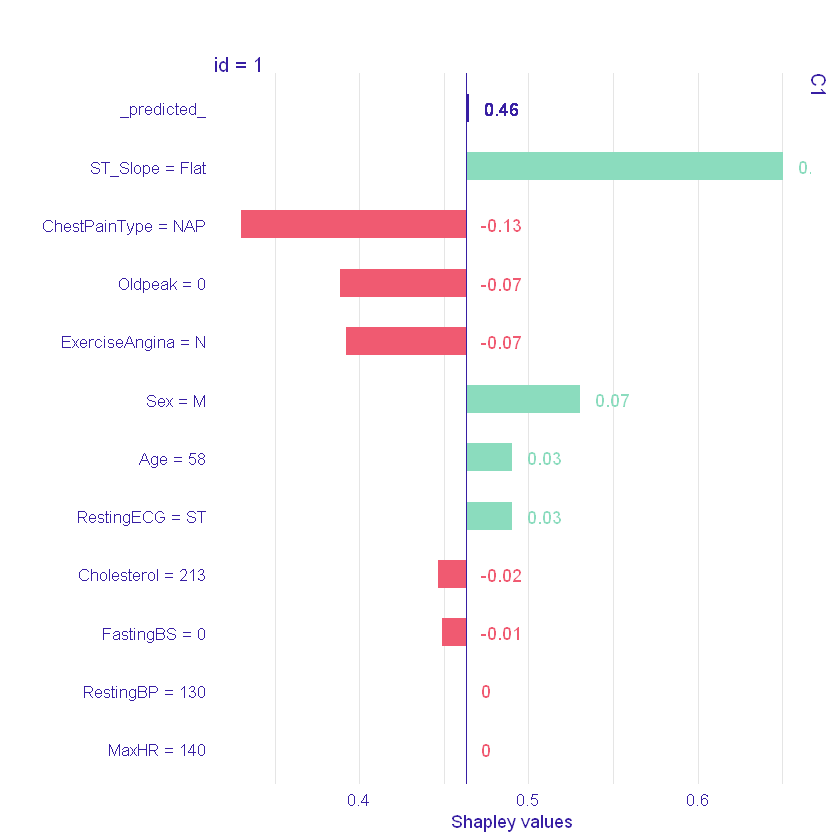

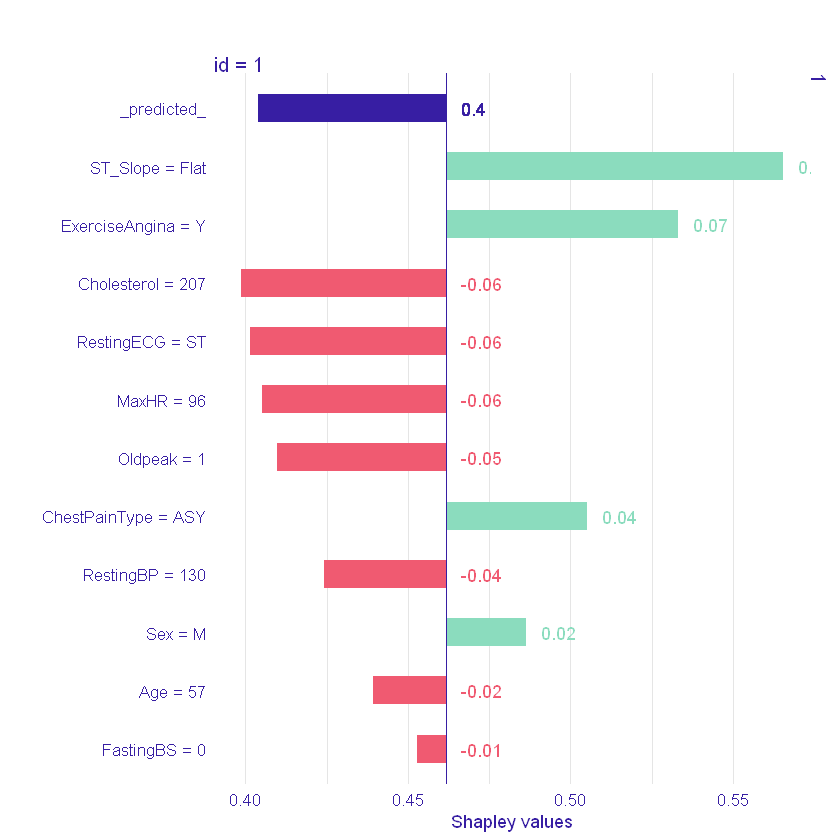

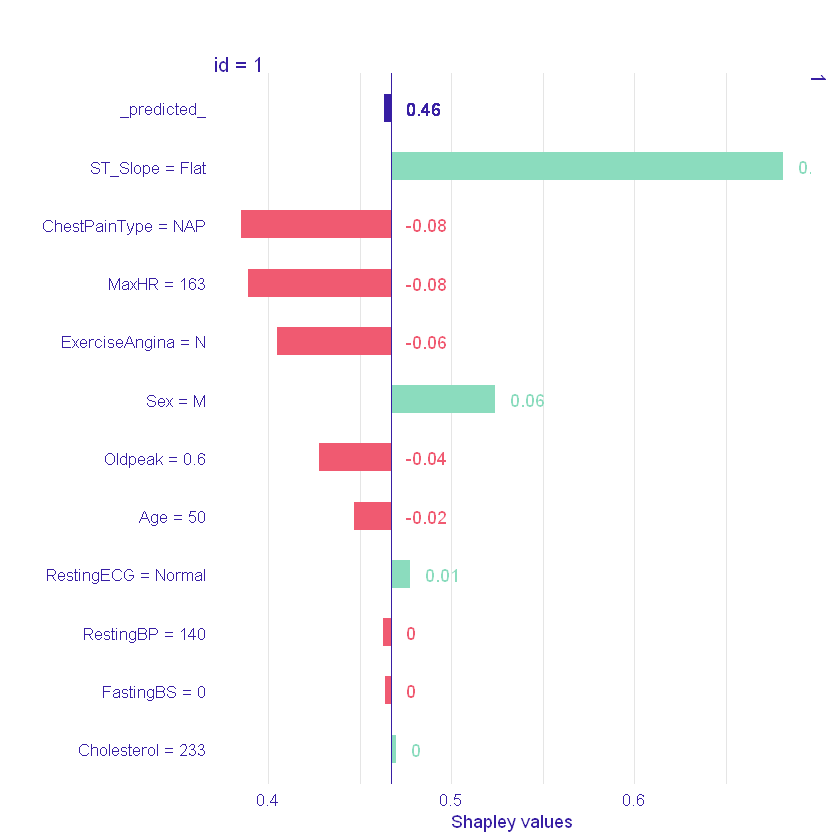

In [36]:
### Check Target Sensitivity for SHAP
library(shapper)
#Create explanation
adv_shap_lr <- individual_variable_effect(lr.heartdisease, data = data_train, 
                                          predict_function = pred_lr, new_observation = changed_A_lr, nsamples=100)
adv_shap_rf <- individual_variable_effect(rf.heartdisease, data = data_train, 
                                          predict_function = pred_rf, new_observation = changed_A_rf, nsamples=100)
adv_shap_svm <- individual_variable_effect(svm.heartdisease, data = data_train, 
                                          predict_function = pred_svm, new_observation = changed_A_svm, nsamples=100)
#Compare with explanations for instance A!!
# filtered lr- only class 1
ive_lr_filtered <- dplyr::filter(adv_shap_lr, `_ylevel_` == "C1")
shapper:::plot.individual_variable_effect(ive_lr_filtered)
# filtered rf- only class 1
ive_rf_filtered <- dplyr::filter(adv_shap_rf, `_ylevel_` == "1")
shapper:::plot.individual_variable_effect(ive_rf_filtered)
# filtered svm- only class 1
ive_svm_filtered <- dplyr::filter(adv_shap_svm, `_ylevel_` == "1")
shapper:::plot.individual_variable_effect(ive_svm_filtered)

**L2 norm SHAP**

In [24]:
library("wavethresh")
ive_lr_filtered <- dplyr::filter(adv_shap_lr, `_ylevel_` == "C1")
label_1 = shap_lr_A[,1]
label_0 = ive_lr_filtered["_attribution_"][,1]
paste0("LR: ", round(l2norm(label_1,label_0),2))

[1] "LR: 0.23"

In [29]:
ive_rf_filtered <- dplyr::filter(adv_shap_rf, `_ylevel_` == "1")
label_1 = shap_rf_A[,1]
label_0 = ive_rf_filtered["_attribution_"][,1]
paste0("RF: ", round(l2norm(label_1,label_0),2))

[1] "RF: 0.23"

In [30]:
ive_svm_filtered <- dplyr::filter(adv_shap_svm, `_ylevel_` == "1")
label_1 = shap_svm_A[,1]
label_0 = ive_svm_filtered["_attribution_"][,1]
paste0("SVM: ", round(l2norm(label_1,label_0),2))

[1] "SVM: 0.21"

## Faithfulness - WB Check

In [13]:
#Impor linear model
mod.lm <- readRDS("Models/WB.lm.rds")

In [14]:
# Fixed functions and results based on them - example of the weigthed average university grade
# ==========================================
x1 <- x2 <- x3 <- seq(10, 20, 0.5)
pm <- expand.grid(x1, x2, x3)
colnames(pm) <- c("x1", "x2", "x3")
mean(x1)
nrow(pm)

# Instances to compute the average and confirm explanations
c <- data.frame(x1=10, x2=19, x3=15) #Paul - 15.2
c1 <- data.frame(x1=15, x2=15, x3=15) #Average - y=15
c2 <- data.frame(x1=20, x2=20, x3=20) #Maximum - y=20

[1] 15

[1] 9261

In [15]:
#create predictor
pred_function <- function(model, data) predict(model, data)

[1] "SHAP values for linear function with x1=10, x2=18, x3=15"
[1] "x1: SHAP=-0.999999999999915"
[1] "x2: SHAP=1.19999999999995"
[1] "x3: SHAP=0"


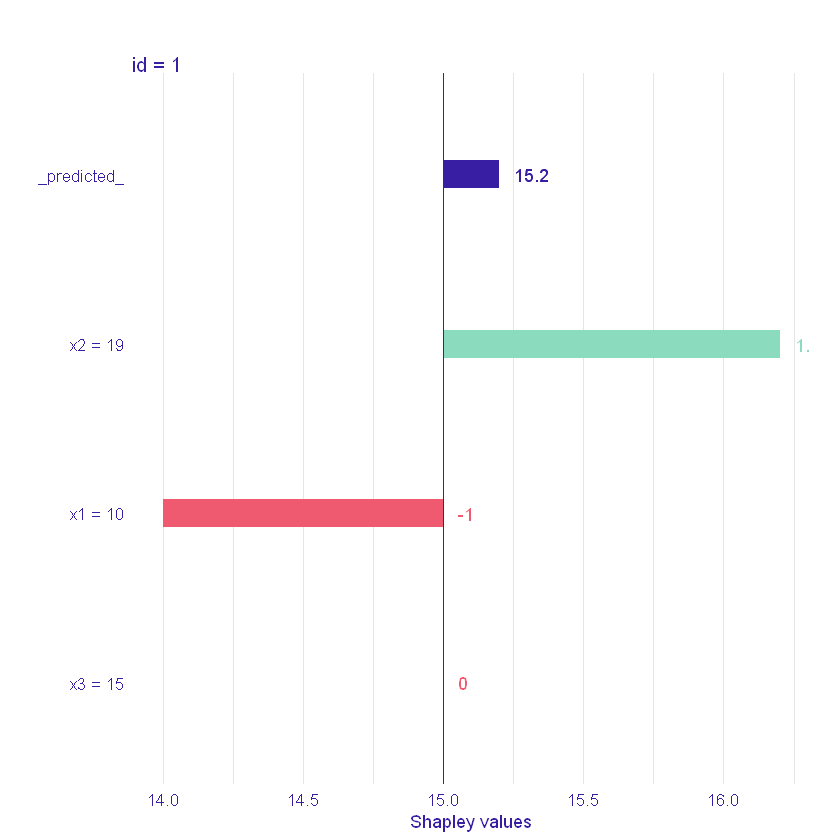

In [44]:
library(shapper)
#Paul
ive_lm <- individual_variable_effect(mod.lm, data = pm, predict_function = pred_function, new_observation = c, nsamples=100)
print("SHAP values for linear function with x1=10, x2=18, x3=15")
for ( i in 1:ncol(pm) )
  print(paste0("x", i, ": SHAP=", ive_lm["_attribution_"][i,]))
plot(ive_lm)

In [45]:
#Average
ive_lm <- individual_variable_effect(mod.lm, data = pm, predict_function = pred_function, new_observation = c1)
print("SHAP values for linear function with x1=15, x2=15, x3=15")
for ( i in 1:ncol(pm) )
  print(paste0("x", i, ": SHAP=", ive_lm["_attribution_"][i,]))
#Maximum
print("SHAP values for linear function with x1=20, x2=20, x3=20")
ive_lm <- individual_variable_effect(mod.lm, data = pm, predict_function = pred_function, new_observation = c2)
for ( i in 1:ncol(pm) )
  print(paste0("x", i, ": SHAP=", ive_lm["_attribution_"][i,]))

[1] "SHAP values for linear function with x1=15, x2=15, x3=15"
[1] "x1: SHAP=0"
[1] "x2: SHAP=0"
[1] "x3: SHAP=0"
[1] "SHAP values for linear function with x1=20, x2=20, x3=20"
[1] "x1: SHAP=1.00000000000007"
[1] "x2: SHAP=1.50000000000002"
[1] "x3: SHAP=2.49999999999991"


In [17]:
source("Global.R")
library(shapper)

In [18]:
# Compute global values for linear model;n.inst = 1000
system.time(gShap.lm <- globalShap(mod.lm, pm, pred_function, ninst=1000))

   user  system elapsed 
3289.44   33.58 3630.86 

In [19]:
gShap.lm

,phi,sd
x1,0.2100628,0.1428386
x2,0.3062214,0.1841722
x3,0.4837111,0.2130596


## Stability

### Identity

In [16]:
source("Benchmark.R")

Loading required package: lattice
Loading required package: ggplot2

Attaching package: 'ggplot2'

The following object is masked from 'package:randomForest':

    margin


Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



In [18]:
library(shapper)
system.time(shap_sens_lr <- identity(instance, pred_lr, model = lr.heartdisease, data = data_train, class.idx=2))

   user  system elapsed 
  86.81    4.24  110.83 

In [19]:
round(sens_result(shap_sens_lr),2)

[1] 0.06

Using method as id variables


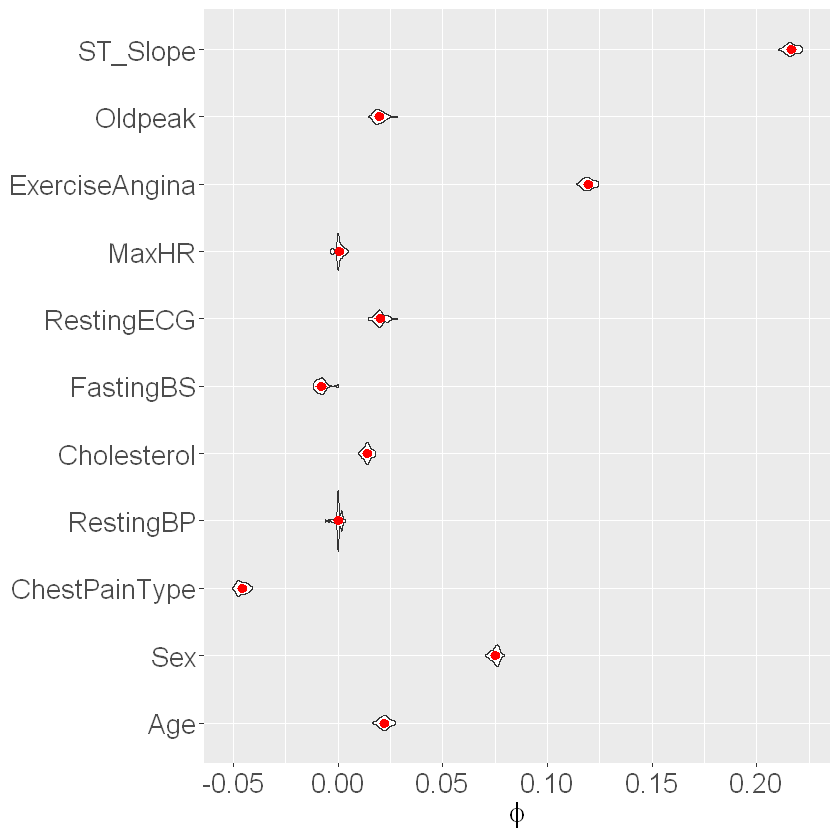

In [20]:
shap_sens_lr$method <- "shap"
sens_plot(shap_sens_lr)

In [21]:
system.time(shap_sens_rf <- identity(instance, pred_rf, model = rf.heartdisease, data = data_train, class.idx=2))

   user  system elapsed 
 129.40    0.71  141.22 

In [22]:
round(sens_result(shap_sens_rf),2)

[1] 0.06

Using method as id variables


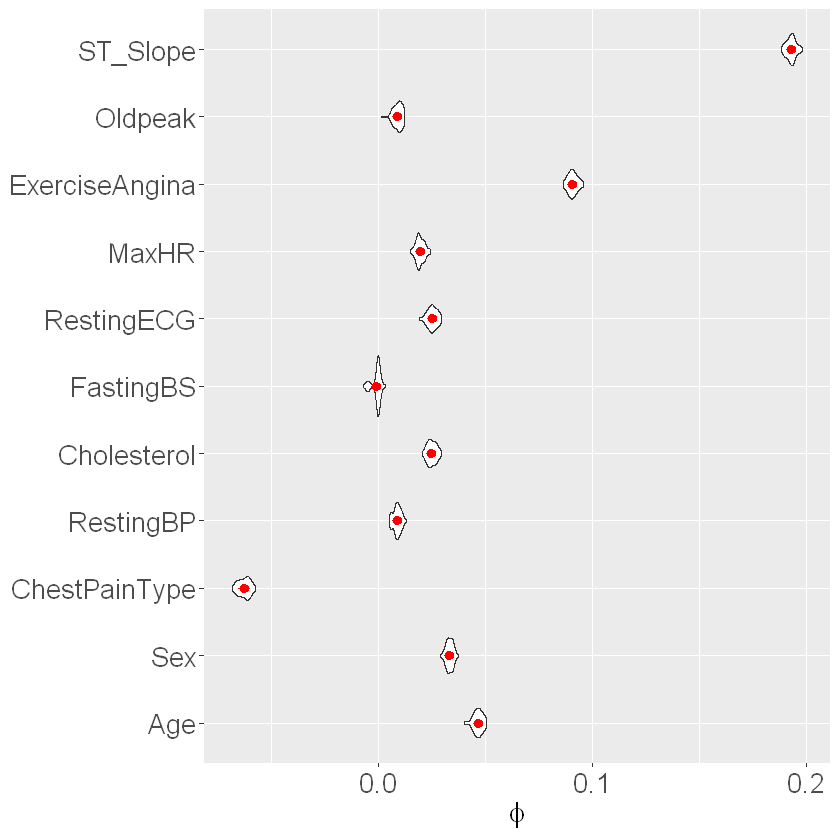

In [23]:
shap_sens_rf$method <- "shap"
sens_plot(shap_sens_rf)

In [24]:
system.time(shap_sens_svm <- identity(instance, pred_svm, model = svm.heartdisease, data = data_train, class.idx=2))

   user  system elapsed 
 133.32    1.45  141.92 

In [25]:
round(sens_result(shap_sens_svm),2)

[1] 0.05

Using method as id variables


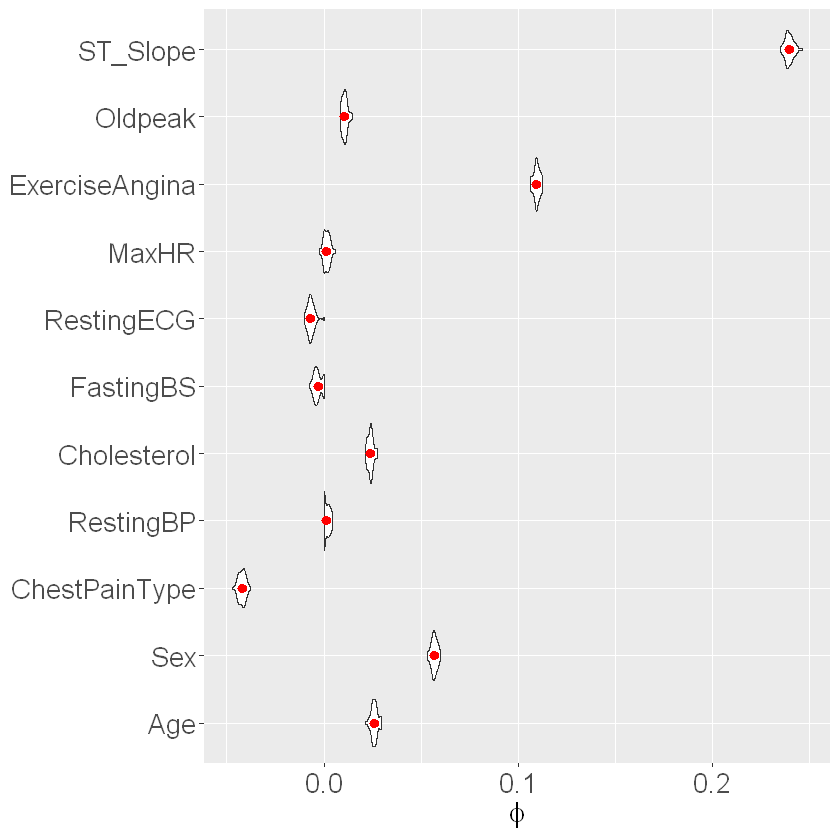

In [27]:
shap_sens_svm$method <- "shap"
sens_plot(shap_sens_svm)

## Similarity

In [30]:
neighbors_lr = find_neighbors(instance, data_train, lr.heartdisease, pred.func = pred_lr, mode = "classification", 
                           n.neighbors=2, class.idx = 2) 
neighbors_rf = find_neighbors(instance, data_train, rf.heartdisease, pred.func = pred_rf, mode = "classification", 
                           n.neighbors=5, class.idx = 2) 
neighbors_svm = find_neighbors(instance, data_train, svm.heartdisease, pred.func = pred_svm, mode = "classification", 
                           n.neighbors=2, class.idx = 2) 

In [32]:
neighbors_lr
neighbors_rf
neighbors_svm

Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,dist,pred
57,M,ATA,140,265,0,ST,145,Y,1.0,Flat,0.00000000,0.8971121
58,M,ATA,136,164,0,ST,99,Y,2.0,Flat,0.09340672,0.9121764
58,M,NAP,137,232,0,ST,124,Y,1.4,Flat,0.13064384,0.8798940


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,dist,pred
1,57,M,ATA,140,265,0,ST,145,Y,1.0,Flat,0.00000000,0.850
2,58,M,ATA,136,164,0,ST,99,Y,2.0,Flat,0.09340672,0.934
5,63,M,ATA,139,217,1,ST,128,Y,1.2,Flat,0.13417599,0.944


Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,dist,pred
57,M,ATA,140,265,0,ST,145,Y,1.0,Flat,0.00000000,0.8841126
58,M,ATA,136,164,0,ST,99,Y,2.0,Flat,0.09340672,0.9335211
58,M,NAP,137,232,0,ST,124,Y,1.4,Flat,0.13064384,0.9275228


In [31]:
nrow(neighbors_lr)-1
nrow(neighbors_rf)-1
nrow(neighbors_svm)-1

[1] 2

[1] 2

[1] 2

In [33]:
library(shapper)
system.time(shap_sens_lr <- similarity(neighbors_lr, pred_lr, model = lr.heartdisease, data = data_train, class.idx=2))
system.time(shap_sens_rf <- similarity(neighbors_rf, pred_rf, model = rf.heartdisease, data = data_train,  class.idx=2))
system.time(shap_sens_svm <- similarity(neighbors_svm, pred_svm, model = svm.heartdisease, data = data_train,  class.idx=2))

[1] "Similarity analysis..."


   user  system elapsed 
   3.87    0.00    3.92 

[1] "Similarity analysis..."


   user  system elapsed 
   7.68    0.05    7.93 

[1] "Similarity analysis..."


   user  system elapsed 
   8.00    0.11    8.45 

In [34]:
round(sens_result(shap_sens_lr),2)
round(sens_result(shap_sens_rf),2)
round(sens_result(shap_sens_svm),2)

[1] 0.25

[1] 0.28

[1] 0.38

Using method as id variables
Using method as id variables


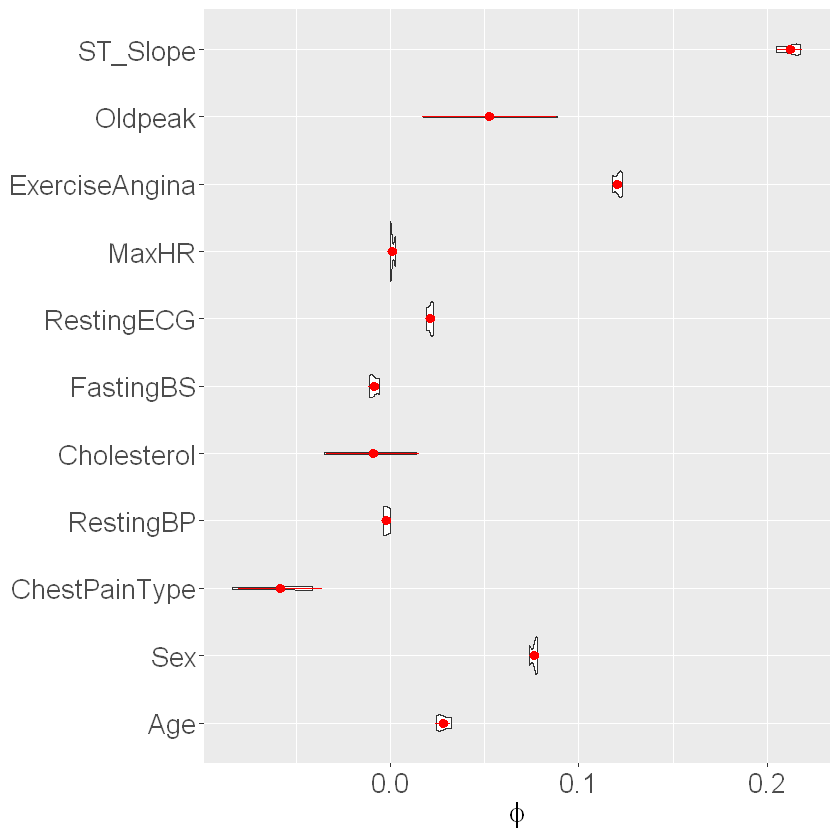

Using method as id variables


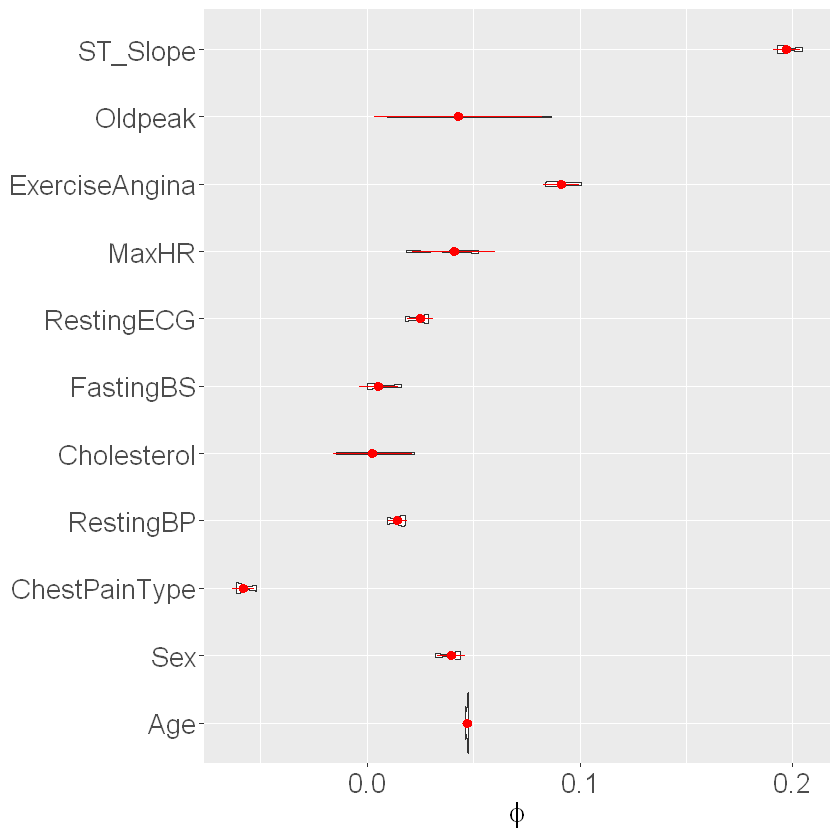

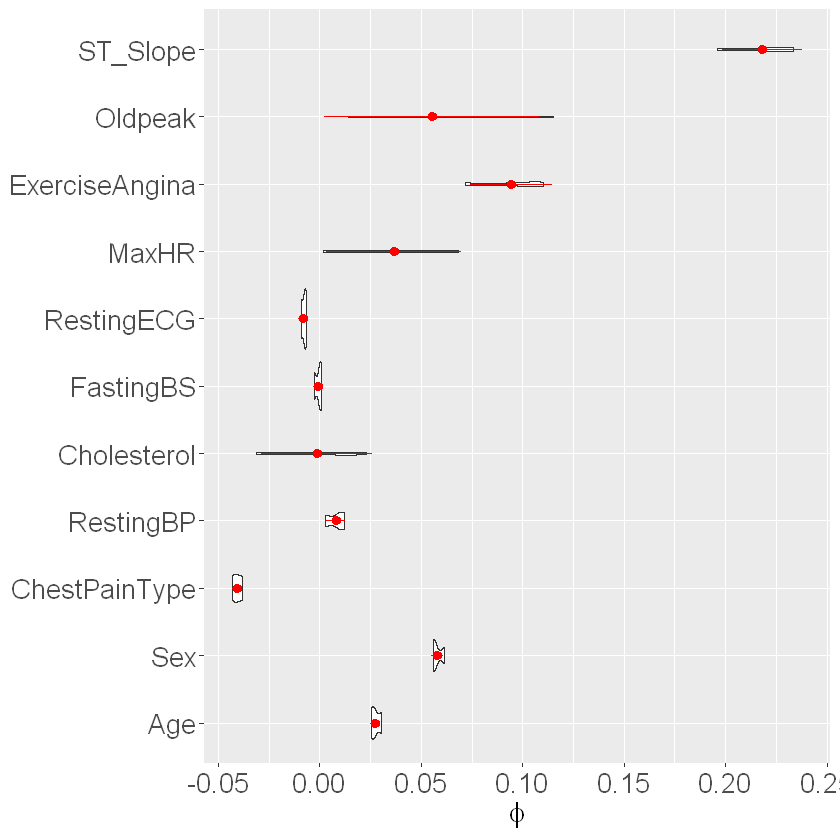

In [35]:
shap_sens_lr$method <- "shap"
sens_plot(shap_sens_lr)
shap_sens_rf$method <- "shap"
sens_plot(shap_sens_rf)
shap_sens_svm$method <- "shap"
sens_plot(shap_sens_svm)

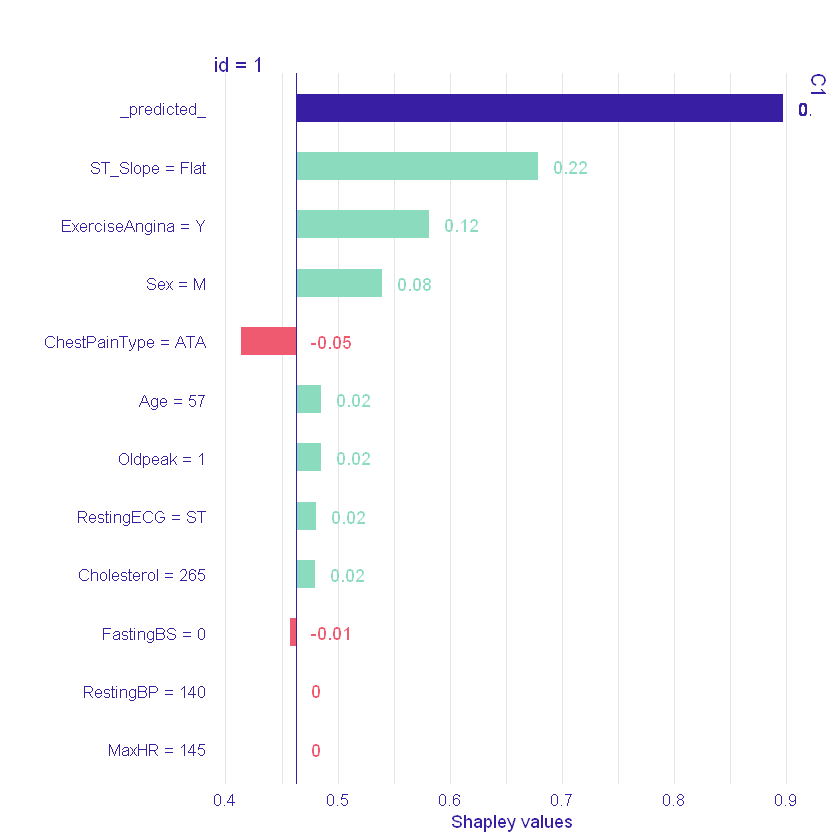

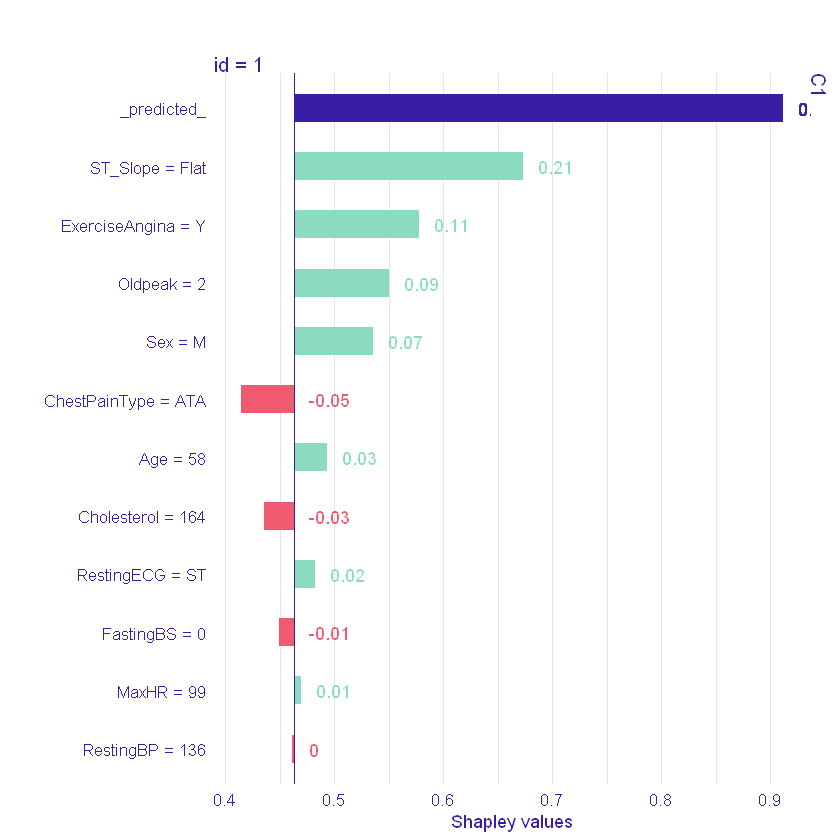

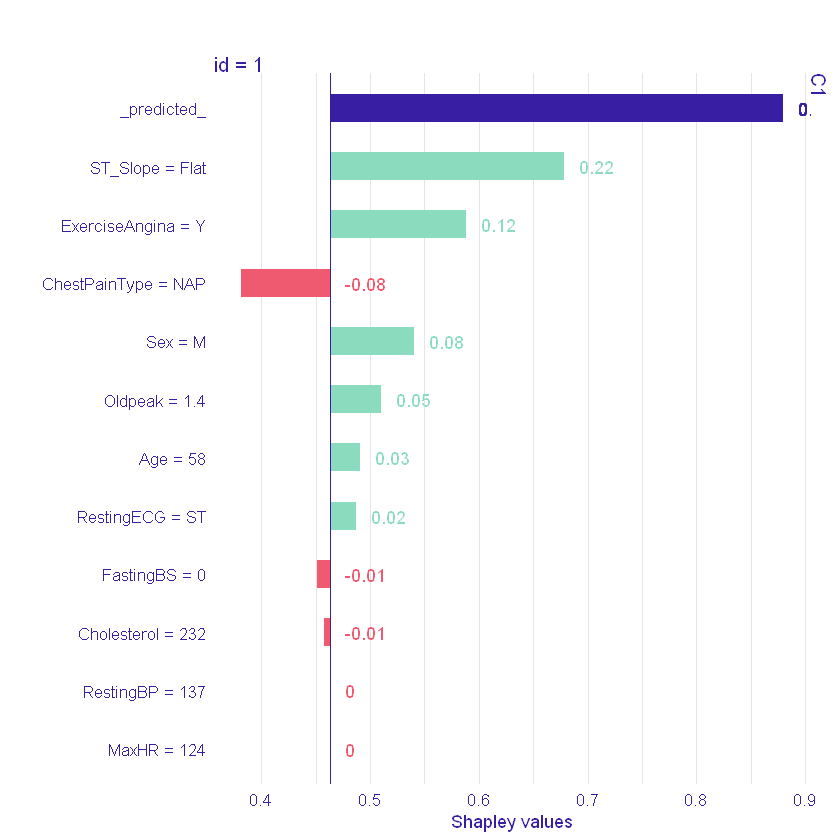

In [37]:
#plot explanations for closest neighbors (top 2)
ive <- individual_variable_effect(lr.heartdisease, data = data_train, 
                                  predict_function = pred_lr,new_observation = neighbors_lr[1,1:11], nsamples=100)
ive_filtered <- dplyr::filter(ive, `_ylevel_` == "C1")
shapper:::plot.individual_variable_effect(ive_filtered)
ive1 <- individual_variable_effect(lr.heartdisease, data = data_train, 
                                  predict_function = pred_lr,new_observation = neighbors_lr[2,1:11], nsamples=100)
ive_filtered1 <- dplyr::filter(ive1, `_ylevel_` == "C1")
shapper:::plot.individual_variable_effect(ive_filtered1)
ive2 <- individual_variable_effect(lr.heartdisease, data = data_train, 
                                  predict_function = pred_lr,new_observation = neighbors_lr[3,1:11], nsamples=100)
ive_filtered2 <- dplyr::filter(ive2, `_ylevel_` == "C1")
shapper:::plot.individual_variable_effect(ive_filtered2)